In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv('M317.csv')
df.shape

(317, 3)

In [13]:
df.tail()

,label,id,sequence
312,Matrix,P61603,AGQAFRKFLPLFDRVLVERSAAETVTKGGIMLPEKSQGKVLQATVV...
313,Matrix,Q99NB1,MAARSLGSGVGRLLRGLQGRSGQSGWSLSVSRSTATRLPGCVPAAA...
314,Matrix,P00431,MTTAVRLLPSLGRTAHKRSLYLFSAAAAAAAAATFAYSQSQKRSSS...
315,Matrix,P18687,MLRLPTVLRQMRPVSRALAPHLTRAYAKDVKFGADARALMLQGVDL...
316,Matrix,P38910,MSTLLKSAKSIVPLMDRVLVQRIKAQAKTASGLYLPEKNVEKLNQA...


at least 41 instances per class
317 instances before
317 instances after


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


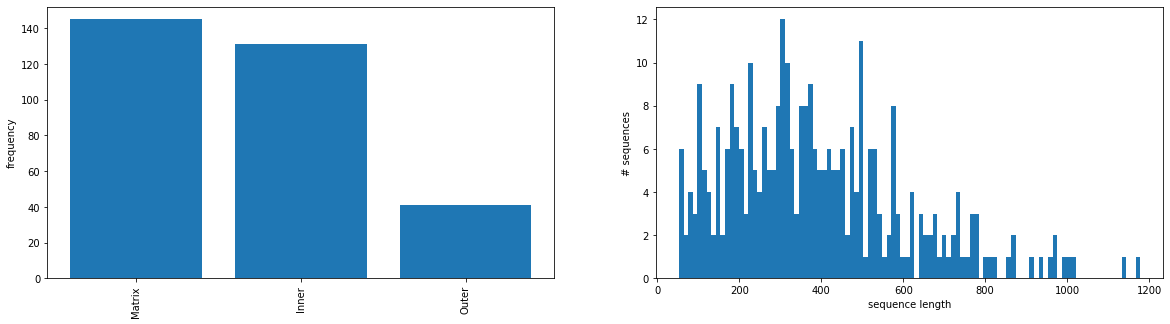

In [14]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.label)
# select only 10 most common classes!
top_classes = 3
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.label]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=100, normed=False)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

In [15]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.label)

In [16]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# maximum length of sequence, everything afterwards is discarded!
max_length = 800

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

Shape of X before SMOTE: (317, 800)
Shape of X after SMOTE: (435, 800)


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


<BarContainer object of 3 artists>

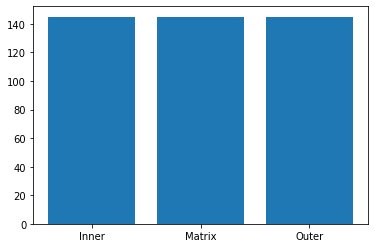

In [22]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, Y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}''')
a = []
for i in range(len(y_sm)):
    if y_sm[i][0] == 1:
        a.append("Inner") 
    elif y_sm[i][1] == 1:
        a.append("Matrix")
    else:
        a.append("Outer")  
plt.bar(x = ['Inner', 'Matrix', 'Outer'], height = [a.count('Inner'), a.count('Matrix'), a.count('Outer')])

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

embedding_dim = 20

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 800, 20)           420       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 800, 64)           3904      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 400, 64)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 400, 32)           6176      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 200, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 200, 16)           1552      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 100, 16)          

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.2)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

Train on 348 samples, validate on 87 samples
Epoch 1/10
348/348 [==============================] - 1s 3ms/step - loss: 1.0939 - accuracy: 0.3649 - val_loss: 1.0533 - val_accuracy: 0.4483
Epoch 2/10
348/348 [==============================] - 1s 2ms/step - loss: 1.0339 - accuracy: 0.4799 - val_loss: 1.0298 - val_accuracy: 0.4483
Epoch 3/10
348/348 [==============================] - 1s 2ms/step - loss: 0.9956 - accuracy: 0.5201 - val_loss: 0.9844 - val_accuracy: 0.4713
Epoch 4/10
348/348 [==============================] - 1s 2ms/step - loss: 0.9503 - accuracy: 0.5977 - val_loss: 0.9341 - val_accuracy: 0.5057
Epoch 5/10
348/348 [==============================] - 1s 2ms/step - loss: 0.8698 - accuracy: 0.5632 - val_loss: 0.8285 - val_accuracy: 0.6552
Epoch 6/10
348/348 [==============================] - 1s 2ms/step - loss: 0.6946 - accuracy: 0.7241 - val_loss: 0.8596 - val_accuracy: 0.6782
Epoch 7/10
348/348 [==============================] - 1s 2ms/step - loss: 0.5913 - accuracy: 0.7471 - v

train-acc = 0.9568965517241379
test-acc = 0.7816091954022989


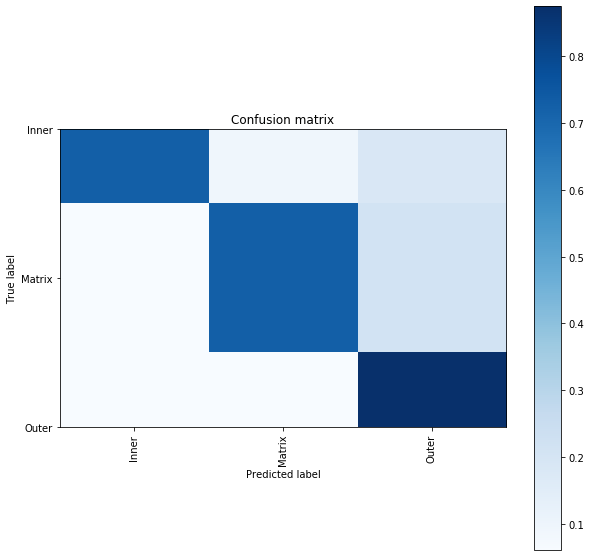

              precision    recall  f1-score   support

       Inner       0.80      0.73      0.76        22
      Matrix       0.86      0.73      0.79        33
       Outer       0.72      0.88      0.79        32

    accuracy                           0.78        87
   macro avg       0.79      0.78      0.78        87
weighted avg       0.79      0.78      0.78        87



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))

In [31]:
model.save('model317.h5')